In [6]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

check_gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "available" if check_gpu \
      else "NOT AVAILABLE" )

#tipos de datos 
DTYPE = 'float32'
tf.keras.backend.set_floatx(DTYPE)   #establece el tipo de float predeterminado

GPU is available


## Objetivo Principal

En este documento se resuelve la ecuación de Poisson para un problema directo e inverso, usando redes neuronales informadas por la física (PINN). 

## Problema Directo

Hallar $u=u(x,y)$ tal que: 

1. $$\dfrac{\partial^2 u}{\partial x^2} + \dfrac{\partial^2 u}{\partial y^2} = f \hspace{0.4cm}  \text{En el interior de } \Omega$$
2. $$u\vert_{\partial \Omega} = 0.$$

para $(x,y)\in [0,2]\times [0,2]$ y $f(x,y)=12(x^2 + y^2) - 24(x+y)$. 

La solución exacta de la EDP anterior es conocida, y viene dada por 
$$u(x,y)= 6xy(x-2)(y-2).$$ 

## Enfoque PINNs 
Considere los siguientes conjuntos de puntos:

$\{x_j^{e},y_j^{e}\}_{j=1}^{N_e}$ un conjunto de puntos en el interior de $\Omega$.

$\{x_j^{1},y_j^{1}\}_{j=1}^{N_1}$ un conjunto de puntos en $[0,2]\times\{0\}$. 

$\{x_j^{2},y_j^{2}\}_{j=1}^{N_2}$ un conjunto de puntos en $[0,2]\times\{2\}$.

$\{x_j^{3},y_j^{3}\}_{j=1}^{N_3}$ un conjunto de puntos en $\{0\}\times [0,2]$.

$\{x_j^{4},y_j^{4}\}_{j=1}^{N_4}$ un conjunto de puntos en $\{2\}\times [0,2]$.

De lo anterior, se define $\{x_j^{b},y_j^{b}\}_{j=1}^{N_b}$ como la union de los cuatro conjuntos definidos sobre el borde.



Sea $\hat{u}(x,y; \vec{\theta})$ una red neuronal feed-forward con dos neuronas de entradas, una neurana de salida, con $l$ capas ocultas de $l_n$ neuronas para cada capa oculta. El enfoque PINNs sostiene que la solución del problema 1-2 se reduce a determinar los pesos y sesgos (vector $\vec{\theta}$) de la red $\hat{u}$ que minimiza la siguiente función de pérdida:

$$\mathcal{L}(\vec{\theta}) =  \dfrac{1}{N_b}\sum\limits_{j=1}^{N_b} |u(x_j^{b},y_j^{b}) - \hat{u}(x_j^{b},y_j^{b}, \vec{\theta}) |^2 
+ \dfrac{1}{N_e}\sum\limits_{j=1}^{N_e} \left| \dfrac{\partial^2 \hat{u}(x_j^{e},y_j^{e}, \vec{\theta})}{\partial x^2} + \dfrac{\partial^2 \hat{u}(x_j^{e},y_j^{e}, \vec{\theta})}{\partial y^2} - f(x_j^{e},y_j^{e}) \right|^2. $$

## Dominios

In [7]:
xmax = 2.0
xmin = 0.0
ymax = 2.0
ymin = 0.0

In [8]:
N_r = 1200

x_r = tf.constant(xmin + (xmax - xmin) * np.random.rand(N_r), shape = (N_r, 1), dtype = DTYPE)
y_r = tf.constant(ymin + (ymax - ymin) * np.random.rand(N_r), shape = (N_r, 1), dtype = DTYPE)
X_r = tf.concat([x_r, y_r], axis = 1)

Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



2024-04-20 19:45:01.513155: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-04-20 19:45:01.513678: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [9]:
N_u = 100 

#borde (x,0)
x_1 = tf.constant(xmin + (xmax - xmin) * np.random.rand(N_u, 1), dtype = DTYPE)
y_1 = tf.ones((N_u, 1), dtype = DTYPE) * ymin
X_1 = tf.concat([x_1, y_1], axis = 1)

#borde (x,2)
x_2 = tf.constant(xmin + (xmax - xmin) * np.random.rand(N_u, 1), dtype = DTYPE)
y_2 = tf.ones((N_u, 1), dtype = DTYPE) * ymax
X_2 = tf.concat([x_2, y_2], axis = 1)

#borde(0,y)
x_3 = tf.ones((N_u, 1), dtype = DTYPE) * xmin
y_3 = tf.constant(ymin + (ymax - ymin) * np.random.rand(N_u, 1), dtype = DTYPE)
X_3 = tf.concat([x_3, y_3], axis = 1)

#borde(2,y)
x_4 = tf.ones((N_u, 1), dtype = DTYPE) * xmax
y_4 = tf.constant(ymin + (ymax - ymin) * np.random.rand(N_u, 1), dtype = DTYPE)
X_4 = tf.concat([x_4, y_4], axis = 1)

Text(0, 0.5, 'x')

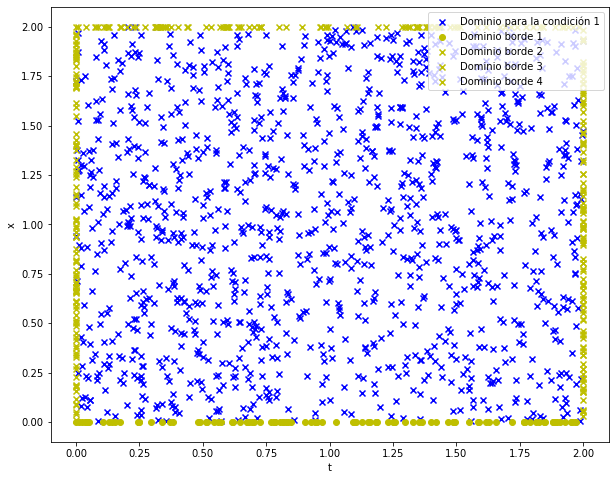

In [10]:
plt.figure(figsize=(10,8))
plt.scatter(x_r, y_r, marker = 'x', color = 'b', label = 'Dominio para la condición 1')
plt.scatter(x_1, y_1, marker = 'o', color = 'y', label = 'Dominio borde 1')
plt.scatter(x_2,y_2, marker = 'x', color = 'y', label = 'Dominio borde 2' )
plt.scatter(x_3, y_3, marker = 'x', color = 'y', label = 'Dominio borde 3' )
plt.scatter(x_4, y_4, marker = 'x', color = 'y', label = 'Dominio borde 4' )
plt.legend(loc='upper right')
plt.xlabel('t')
plt.ylabel('x')

## Funciones para definir la condicion inicial, condición de borde y EDP

In [11]:
def f(X):
    x = X[:,0:1]
    y = X[:,1:2]
    return 12 * ( x**2 + y**2 ) - 24 * ( x + y )

def g(X):
    x = X[:,0:1]
    y = X[:,1:2]
    return tf.zeros_like(x)


In [12]:
def f_res(u_xx, y_xx):
    return u_xx + y_xx 

## Red Neuronal

In [13]:
#Red Neuronal
def init_model(num_hidden_layers = 3, num_neurons_per_layer = 20 ):
    model = tf.keras.Sequential()
    model.add(tf.keras.Input(2))

    for _ in range(num_hidden_layers):
        model.add(tf.keras.layers.Dense(num_neurons_per_layer, 
                                        activation = tf.keras.activations.get('tanh'),
                                       kernel_initializer = 'glorot_normal'))
    
    model.add(tf.keras.layers.Dense(1))
    return model

In [14]:
model_1 = init_model()

In [15]:
#Derivadas de la red neuronal
def get_diff(model, X):
    x = X[:,0:1]
    y = X[:,1:2]
    with tf.GradientTape(persistent=True) as outer_tape:
        outer_tape.watch(x)
        outer_tape.watch(y)
        with tf.GradientTape(persistent=True) as inner_tape:
            inner_tape.watch(x)
            inner_tape.watch(y)
            u = model(tf.concat([x, y], axis = 1))
        u_x = inner_tape.gradient(u, x)
        u_y = inner_tape.gradient(u, y)
    u_xx = outer_tape.gradient(u_x, x)
    u_yy = outer_tape.gradient(u_y, y)
    return  u_xx, u_yy   

## Función de Pérdida

In [16]:
def compute_loss(model, X_colocacion, X_borde_1, X_borde_2, X_borde_3, X_borde_4):
    
    u_xx, u_yy = get_diff(model, X_colocacion)
    loss_r = tf.reduce_mean(tf.square(f_res(u_xx,u_yy) - f(X_colocacion) ))

    loss_bc_1 = tf.reduce_mean(tf.square(model(X_borde_1) - g(X_borde_1)))
    loss_bc_2 = tf.reduce_mean(tf.square(model(X_borde_2) - g(X_borde_2)))
    loss_bc_3 = tf.reduce_mean(tf.square(model(X_borde_3) - g(X_borde_3)))
    loss_bc_4 = tf.reduce_mean(tf.square(model(X_borde_4) - g(X_borde_4)))
  
    loss = loss_r + loss_bc_1 + loss_bc_2 + loss_bc_3 + loss_bc_4
    return loss, loss_r, loss_bc_1, loss_bc_2, loss_bc_3, loss_bc_4

In [17]:
#Derivada de la función de pérdida con respecto a los pesos de la red neuronal
def loss_grad(model, X_colocacion, X_borde_1, X_borde_2, X_borde_3, X_borde_4):
    with tf.GradientTape() as tape:
        loss, _, _, _, _, _ = compute_loss(model, X_colocacion, X_borde_1, X_borde_2, X_borde_3, X_borde_4)
    g = tape.gradient(loss, model.trainable_variables)
    return loss, g

In [18]:
optim = tf.keras.optimizers.Adam(0.001)

In [20]:
#Función que realiza un paso en el preceso de descenso de gradiente aplicado a la función de pérdida
@tf.function 
def train_step(model, X_colocacion, X_borde_1, X_borde_2, X_borde_3, X_borde_4):
    loss, grad_theta = loss_grad(model, X_colocacion, X_borde_1, X_borde_2, X_borde_3, X_borde_4)
    
    optim.apply_gradients(zip(grad_theta, model.trainable_variables))  #un paso descenso de gradiente
    return loss

In [21]:
#diccionario que guardará el conmputo de las componentes de la loss
hist = {'loss': [],
        'r_pinn': [],
        'r_1': [],
        'r_2': [],
        'r_3': [],
        'r_4': [], 
        } 

In [22]:
from time import time  

#Número de Épocas
N = 10000

#Comienzo del tiempo
t0 = time()

#Entrenamiento
for i in range(N+1):
    #Actualización de los pesos de la función de pérdida 
    loss = train_step(model_1, X_r, X_1, X_2, X_3, X_4)  
    _, r_pinn, r_1, r_2, r_3, r_4 = compute_loss(model_1, X_r, X_1, X_2, X_3, X_4)  

    hist['loss'].append(loss.numpy())
    hist['r_pinn'].append(r_pinn.numpy())
    hist['r_1'].append(r_1.numpy())
    hist['r_2'].append(r_2.numpy())
    hist['r_3'].append(r_3.numpy())
    hist['r_4'].append(r_4.numpy())

    #Visualiza el avance de la función de pérdida
    if i%1000 == 0:
        print(f'It {i:05d}: loss = {loss:10.8e}')
        
#Mostrar tiempo de calculo 
print(f'Tiempo de Cómputo: {time()-t0} segundos')


2024-04-20 19:49:02.260318: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2024-04-20 19:49:02.265915: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


It 00000: loss = 2.77763062e+02
It 01000: loss = 1.15966320e+00
It 02000: loss = 2.63017625e-01
It 03000: loss = 1.01445906e-01
It 04000: loss = 5.43150231e-02
It 05000: loss = 3.49534340e-02
It 06000: loss = 2.15936229e-02
It 07000: loss = 1.22853946e-02
It 08000: loss = 7.38281291e-03
It 09000: loss = 4.82430356e-03
It 10000: loss = 3.37833166e-03
Tiempo de Cómputo: 243.83055591583252 segundos


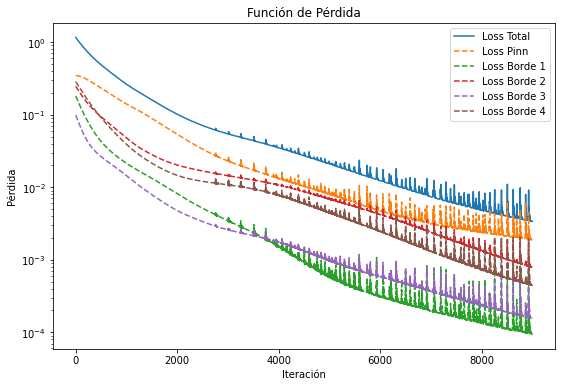

In [25]:
#gráfica pérdida
plt.figure(figsize=(9,6))

plt.plot(range(len(hist['loss'][1000:])), hist['loss'][1000:], label = 'Loss Total')
plt.plot(range(len(hist['r_pinn'][1000:])), hist['r_pinn'][1000:], label = 'Loss Pinn', linestyle = '--')
plt.plot(range(len(hist['r_1'][1000:])), hist['r_1'][1000:], label = 'Loss Borde 1', linestyle = '--')
plt.plot(range(len(hist['r_2'][1000:])), hist['r_2'][1000:], label = 'Loss Borde 2', linestyle = '--')
plt.plot(range(len(hist['r_3'][1000:])), hist['r_3'][1000:], label = 'Loss Borde 3', linestyle = '--')
plt.plot(range(len(hist['r_4'][1000:])), hist['r_4'][1000:], label = 'Loss Borde 4', linestyle = '--')
plt.title('Función de Pérdida')
plt.legend(loc='upper right')
plt.yscale('log')
plt.xlabel('Iteración')
plt.ylabel('Pérdida')
plt.show()

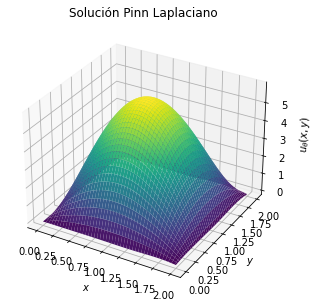

In [26]:
#grafica solución 

N = 500

xspace = np.linspace(xmin, xmax, N + 1)
yspace = np.linspace(ymin, ymax, N + 1)
X, Y = np.meshgrid(xspace, yspace)
Xgrid = np.vstack([X.flatten(),Y.flatten()]).T

# Determine predictions of u(t, x)
upred = model_1(tf.cast(Xgrid,DTYPE))

# Reshape upred
U = upred.numpy().reshape(N+1,N+1)

fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, U, cmap='viridis')
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_zlabel('$u_\\theta(x,y)$')
ax.set_title('Solución Pinn Laplaciano')
plt.show()

### Gráfico Interactivo

In [27]:
from ipywidgets import interactive
import ipywidgets as widgets

#grafica solución 
N = 500

xspace = np.linspace(xmin, xmax, N + 1)
yspace = np.linspace(ymin, ymax, N + 1)
X, Y = np.meshgrid(xspace, yspace)
Xgrid = np.vstack([X.flatten(),Y.flatten()]).T

# Determine predictions of u(t, x)
upred = model_1(tf.cast(Xgrid,DTYPE))

# Reshape upred
U = upred.numpy().reshape(N+1,N+1)

def plot_surface(elev=30, azim=30):
    fig = plt.figure(figsize=(8, 5))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X, Y, U, cmap='viridis')
    ax.view_init(elev, azim)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
    ax.set_zlabel('$u_\\theta(x,y)$')
    ax.set_title('Solucion Pinn Laplaciano')
    plt.show()

elev_slider = widgets.IntSlider(min=0, max=90, step=1, value=30, description='Elevación')
azim_slider = widgets.IntSlider(min=0, max=360, step=1, value=30, description='Azimut')

interactive_plot = interactive(plot_surface, elev=elev_slider, azim=azim_slider)
output = interactive_plot.children[-1]
output.layout.height = '350px'
interactive_plot


interactive(children=(IntSlider(value=30, description='Elevación', max=90), IntSlider(value=30, description='A…

## Problema Inverso

Conocida $u=u(x,y)$, hallar $\lambda$ tal que: 


1. $$\dfrac{\partial^2 u}{\partial x^2} + \lambda \dfrac{\partial^2 u}{\partial y^2} = f(x,y)$$ 
2. $$ u\vert_{\partial \Omega} = 0. $$


para $(x,y)\in \Omega =  [0,2]\times [0,2]$ y $f(x,y)=12(x^2 + y^2) - 24(x+y)$. 

En esta caso, elegimos $u(x,y)= 6xy(x-2)(y-2)$ (note que $u$ satisface la condición 1), entonces el valor exacto de $\lambda$ en la EDP anterior es 1. 

En lo sucesivo, buscamos el valor de $\lambda$ dado un conjunto escaso de valores que toma la solución $u$ sobre el dominio $\Omega$.

## Enfoque PINNs 
Considere los siguientes conjuntos de puntos:

$\{x_j^{e},y_j^{e}\}_{j=1}^{N_e}$ un conjunto de puntos en el interior de $\Omega$.

$\{x_j^{d},y_j^{d}\}_{j=1}^{N_d}$ un conjunto de puntos en $[0,2]\times [0,2]$, donde se conoce $u(x_j^{d},y_j^{d})$ para todo $j$.

Sea $\hat{u}(x,y; \vec{\theta})$ una red neuronal feed-forward con dos neuronas de entradas, una neurana de salida, con $l$ capas ocultas de $l_n$ neuronas para cada capa oculta. El enfoque PINNs sostiene, conociendo información de la solución de 1, el problema de hallar el parámetro $\lambda$ se reduce a determinar los pesos,sesgos (vector $\vec{\theta}$) de la red $\hat{u}$ y el parámetro $\lambda$ que minimiza la siguiente función de pérdida:

$$\mathcal{L}(\vec{\theta}, \lambda) =  \dfrac{1}{N_d}\sum\limits_{j=1}^{N_d} |u(x_j^{d},y_j^{d}) - \hat{u}(x_j^{d},y_j^{d}, \vec{\theta}) |^2 
+ \dfrac{1}{N_e}\sum\limits_{j=1}^{N_e} \left| \dfrac{\partial^2 \hat{u}(x_j^{e},y_j^{e}, \vec{\theta})}{\partial x^2} + \lambda\dfrac{\partial^2 \hat{u}(x_j^{e},y_j^{e}, \vec{\theta})}{\partial y^2} - f(x_j^{e},y_j^{e}) \right|^2. $$